In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


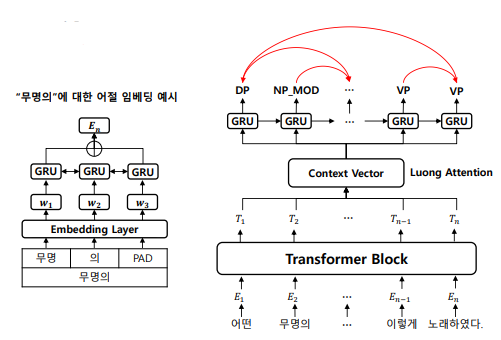

In [2]:
from IPython.display import Image
import os
root_dir = '/gdrive/MyDrive/08-3.DependencyParsing'
Image(os.path.join(root_dir, "DP_practice.PNG"))

In [3]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import (DataLoader, TensorDataset)
import numpy as np
from tqdm import tqdm

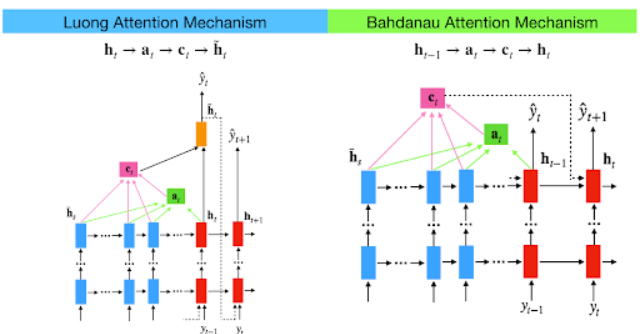

In [4]:
from IPython.display import Image
import os
Image(os.path.join(root_dir, "attention.PNG"))

In [5]:
# 현재 Decoder의 출력과 입력 문자열 사이의 관계(attn_weight)를 계산
# 계산된 weight를 통해 context 벡터 생성
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        # General Loung Attention을 위한 Weight
        self.linear = nn.Linear(in_features=hidden_size*2, out_features=hidden_size*2)

    def forward(self, encoder_outputs, rnn_output):
        # encoder_outputs : [batch, seq, hidden]
        # 인코딩된 입력 문자열
        # rnn_output : [batch, 1, hidden]
        # 현재 디코딩 step Output

        l_rnn_output = self.linear(rnn_output)
        # l_rnn_output : [batch, 1, hidden]

        t_encoder_ouputs = encoder_outputs.transpose(1, 2)
        # t_encoder_outputs : [batch, hidden, seq]

        attn_score = l_rnn_output.bmm(t_encoder_ouputs)
        # attn_outputs : [batch, 1, seq]

        attn_weights = F.softmax(attn_score, -1)
        # attn_weights : [batch, 1, seq]

        context = attn_weights.bmm(encoder_outputs)
        # context : [batch, 1, hidden]

        return context, attn_weights

class Attn_Decoder(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super(Attn_Decoder, self).__init__()
        
        # GRU Decoder 선언
        self.decoder = nn.GRU(input_size=hidden_size*2,
                              hidden_size=hidden_size*2,
                              batch_first=True,
                              num_layers=1)
        
        # Loung Attention Class 선언
        self.attn = Attention(hidden_size)

        # 최종 label 확률 분포로 변환하기 위한 Linear
        self.output_layer = nn.Linear(in_features=hidden_size*4, out_features=num_labels)

    def forward(self, last_hidden, decoder_input, encoder_outputs):
        # last hidden : [1, batch, hidden*2]
        # decoder_input : [batch, hidden*2]
        # encoder_outputs : [batch, seq, hidden*2]

        decoder_input = decoder_input.unsqueeze(1)
        # decoder_input : [batch, 1, hidden*2]

        dec_outputs, dec_hidden = self.decoder(input=decoder_input, hx=last_hidden)
        # dec_outputs : [batch, 1, hidden*2]
        # dec_hidden : [1, batch, hidden*2]

        context, attn_weight = self.attn(encoder_outputs, dec_outputs)
        # context : [batch, 1, hidden*2]
        # attn_weight : [batch, 1, seq]

        outputs = torch.cat([dec_outputs, context], -1)
        # outputs : [batch, 1, hidden*4]

        label_logits = self.output_layer(outputs).squeeze(1)
        # label_logits : [batch, 1, num_labels] => [batch, num_labels]

        head_logits = attn_weight.squeeze(1)
        # head_logits : [batch, seq]

        return label_logits, head_logits, dec_hidden

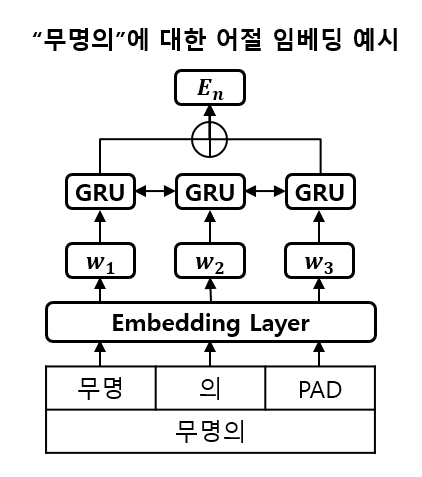

In [6]:
from IPython.display import Image
import os
Image(os.path.join(root_dir, "eojeol_encoding.PNG"))

In [7]:
class DependencyPaser(nn.Module):
    def __init__(self, config):
        super(DependencyPaser, self).__init__()

        # 전체 형태소 개수 (= vocabulary 크기)
        self.word_vocab_size = config["word_vocab_size"]

        # 형태소 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        # 입력 문장을 구성하는 최대 어절 개수
        self.max_eojeol_length = config["max_eojeol_length"]

        # 어절을 구성하는 최대 형태소 개수
        self.max_word_length = config["max_word_length"]

        # 형태소 임베딩 Matrix
        self.embeddings = nn.Embedding(num_embeddings=self.word_vocab_size,
                                           embedding_dim=self.embedding_size,
                                           padding_idx=0)

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # Transformer Attention Head 개수
        self.num_heads = config["num_heads"]

        # 형태소 Encoding layer
        self.word_encoder = nn.GRU(input_size=self.embedding_size,
                                  hidden_size=self.hidden_size,
                                  num_layers=1,
                                  batch_first=True,
                                  bidirectional=True)

        # Transformer Encoder layer
        self.trm_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=self.hidden_size*2,
                                                                                      nhead=self.num_heads,
                                                                                      dim_feedforward=self.hidden_size*2,
                                                                                      batch_first=True),
                                                                                      num_layers=2)

        # Bi-GRU Encoder layer
        self.gru_encoder = nn.GRU(input_size=self.hidden_size*2,
                                  hidden_size=self.hidden_size,
                                  num_layers=1,
                                  batch_first=True,
                                  bidirectional=True)
        self.att_decoder = Attn_Decoder(self.hidden_size, self.number_of_tags)

    def forward(self, inputs_ids):
        # input_ids : [batch, eojeol_seq, word_seq]
        # [batch 개의 데이터, eojeol_seq만큼의 길이, word_seq 길이 만큼의 형태소]

        word_features = self.embeddings(inputs_ids).view(-1, self.max_word_length, self.embedding_size)        
        # word_features : [batch, e_seq, word_seq, emb_size] -> [batch * eojeol_seq, word_seq, embedding_size]

        _, enc_hidden_state = self.word_encoder(word_features)
        # _ : [b*e_seq, word_seq, hidden*2]
        # enc_hidden_state : [2, batch * eojeol_seq, hidden]

        enc_eojeol = torch.cat([enc_hidden_state[0], enc_hidden_state[1]], -1).view(-1, self.max_eojeol_length, self.hidden_size*2)
        # enc_eojeol : [batch * eojeol_seq, hidden*2] => [batch, eojeol_seq, hidden*2]

        trm_encoder_outputs = self.trm_encoder(enc_eojeol)
        # trm_encoder_outputs : [batch, eojeol_seq, hidden*2]

        gru_encoder_outputs, gru_encoder_hidden = self.gru_encoder(trm_encoder_outputs)
        # gru_encoder_outputs : [batch, eojeol_seq, hidden*2]
        # gru_encoder_hidden  : [2, batch, hidden] ==> [batch, hidden*2]
        ##### [1, batch, hidden]

        # 의존 구문 Tag 결과 저장을 위한 List
        decoder_outputs = []

        # 의존 구문 head 결과 저장을 위한 List
        decoder_head_outputs = []

        last_hidden = torch.cat([gru_encoder_hidden[0], gru_encoder_hidden[1]], -1).unsqueeze(0)
        # [batch, hidden*2] => [1, batch, hidden*2]
        
        for step in range(self.max_eojeol_length):
            decoder_input = enc_eojeol[:, step, :]
            # [bathc, eojeol_seq, hidden*2]
            # decoder_input : [batch, hidden*2]

            decoder_output, attn_weight, last_hidden = self.att_decoder(last_hidden, decoder_input, gru_encoder_outputs)
            # decoder_output : [batch, num_labels]
            # attn_weight : [batch, seq]
            # last_hidden : [1, batch, hidden*2]

            decoder_outputs.append(decoder_output)
            decoder_head_outputs.append(attn_weight)

        label_hypothesis = torch.stack(decoder_outputs, 0).transpose(0, 1).contiguous()
        # label_hypothesis : [eoj_seq, batch, num_labels] => [batch, seq, num_labels]

        head_hypothesis = torch.stack(decoder_head_outputs, 0).transpose(0, 1).contiguous()
        # head_hypothesis : [eoj_seq, batch, eoj_seq] => [batch, eoj_seq, eoj_seq]

        return label_hypothesis, head_hypothesis


<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. def read_vocab_data(word_vocab_path, label_vocab_path):</b>
  "vocab.txt", "label_vocab.txt" 파일을 읽고 Vocabulary Dictionary를 만들기 위한 함수

  args
    word_vocab_path : 형태소 단어 파일
    label_vocab_path : 의존 구문 태그 파일
  return

  데이터 예시)
    vocab.txt                     label_vocab.txt
  -------------------------------------------------
    세종/NNP                          <PAD>
    사과/NNG                          ROOT
    의/JKB                            AP
     ...                               ...

    word2idx = {"세종/NNP" : 0, "사과/NNG" : 1, ... }
    idx2word = {0: "세종/NNP", 1: "사과/NNG", ...}

    label2idx = {"<PAD>": 0, "ROOT": 1, ... }
    idx2label = {0: "<PAD>", "ROOT":1, ... }

<b>2. def read_data(config, file_path, word2idx, label2idx):</b>
  학습 또는 평가 데이터를 읽고 고정 길이 텐서로 반환하기 위한 함수
   
  args
    config : 모델 학습 파라미터 및 경로 정보
    file_path : 학습 또는 평가 데이터의 경로
    word2idx : 형태소에 대응하는 인덱스로 변환하기 위한 딕셔너리
    label2idx : 의존 구문 태그에 대응하는 인덱스로 변환하기 위한 딕셔너리
  return  
    all_word_input_ids : [N_samples, max_eojeol_length, max_word_length]
                        -> [[[ROOT], PAD, PAD]	[남/NNP, 과/JC, PAD], [북/NNP, 이/JKS, PAD], ..., ]
                        -> [[1, 0, 0], [123, 456, 0], [126, 23, 0], ... ]
    all_label_ids      : [N_samples, max_eojeol_length]
    all_head_ids       : [N_samples, max_eojeol_length]

    
<b>3. def convert_data2feature(input_sequence, symbol2idx, max_length):</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  args
    input_sequence : 인덱실 하고자 하는 입력 Sequence
    symbol2idx : 인덱스로 치환하기 위한 딕셔너리
    max_length : 고정 길이 텐서로 만들기 위해 필요한 입력 최기 길이
  return
    input_ids : 고정 길이 인덱스 리스트
    
 </pre>


In [8]:


# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(vocab_path):
    symbol2idx, idx2symbol = {}, {}

    vocab_file = open(vocab_path, "r", encoding="utf8").readlines()
    for line in vocab_file:
        symbol = line.strip()
        symbol2idx[symbol] = len(symbol2idx)
        idx2symbol[symbol2idx[symbol]] = symbol
    return symbol2idx, idx2symbol

# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(config, file_path, word2idx, label2idx):
    with open(file_path, "r", encoding="utf8") as infile:
        lines = infile.readlines()
    all_word_input_ids = []
    all_label_ids = []
    all_head_ids = []
    
    for line in tqdm(lines, desc="read_data"):
        # 입력 문장을 \t으로 분리
        pieces = line.strip().split("#%#")

        # 입력 문자열을 어절 단위로 분리

        # 남 과 \t 북 이 \t 갈리 고 ... #%# ROOT NP_CNJ NP_SBJ ... #%# 0 2 3 6 ...
        eojeol_sequence, label_sequence, head_sequence = pieces[0].split("\t"), pieces[1].split(), pieces[2].split()
        
        # 형태소 단위 어절 리스트로 변환
        word_input_ids = [np.zeros(shape=(config["max_word_length"]), dtype=np.int) for e in range(config["max_eojeol_length"])]
        # [어절 길이, 형태소 길이]
        for eojeol_index, eojeol in enumerate(eojeol_sequence):
            eojeol = eojeol.split()
            word_input_ids[eojeol_index] = convert_data2feature(eojeol, word2idx, config["max_word_length"])
        
        all_word_input_ids.append(word_input_ids)
        all_label_ids.append(convert_data2feature(label_sequence, label2idx, config["max_eojeol_length"]))
        all_head_ids.append(convert_data2feature(head_sequence, None, config["max_eojeol_length"]))
        
    all_word_input_ids = torch.tensor(all_word_input_ids, dtype=torch.long)    
    all_label_ids = torch.tensor(all_label_ids, dtype=torch.long)
    all_head_ids = torch.tensor(all_head_ids, dtype=torch.long)

    return all_word_input_ids, all_label_ids, all_head_ids

# 입력 데이터 전처리
def convert_data2feature(input_sequence, symbol2idx, max_length):
    input_ids = np.zeros(shape=(max_length), dtype=np.int)
        
    for index in range(len(input_sequence)):
        if symbol2idx:
            input_ids[index] = symbol2idx[input_sequence[index]]
        else:
            input_ids[index] = int(input_sequence[index])
    return input_ids


In [9]:
# 성능 평가 함수
def accuracy_score(label_answers, head_answers, label_preds, head_preds):
    label_n_samples = 0
    label_n_correct = 0

    head_n_samples = 0
    head_n_correct = 0
    for idx in range(len(label_answers)):
        if label_answers[idx] == 0:
            break
        if head_answers[idx] == head_preds[idx]:
            head_n_correct+=1
            if label_answers[idx] == label_preds[idx]:
                label_n_correct+=1

        label_n_samples+=1
        head_n_samples+=1
    LAS_accuracy = label_n_correct/label_n_samples
    UAS_accuracy = head_n_correct/head_n_samples
    return LAS_accuracy, UAS_accuracy

def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

# 모델 출력 라벨 sequence와 정답 라벨 sequence를 기반으로
# 모델 출력 문장과 정답 문장 출력
def make_sentence(inputs, label_predicts, head_predicts, label_answers, head_answers, idx2word, idx2label):
    inputs = tensor2list(inputs)
    label_predicts = tensor2list(label_predicts)
    head_predicts = tensor2list(head_predicts)

    head_answers = tensor2list(head_answers)
    label_answers = tensor2list(label_answers)

    # 빈 문자열 생성
    strFormat = '%-15s%-35s%-35s\n'
    strOut = strFormat % ('sep1', 'sep2', 'sep3')
    input_sentence = []
    predict_labels = []
    answer_labels = []

    predict_heads = []
    answer_heads = []

    for index in range(len(inputs)):
        if label_answers[index] == 0:
            break
        eojeol = []
        for word_index in range(len(inputs[index])):
            word = idx2word[inputs[index][word_index]]
            if word != "<PAD>":
                eojeol.append(word)
        eojeol = "+".join(eojeol)
        input_sentence.append(eojeol)

        answer_labels.append(idx2label[label_answers[index]])
        predict_labels.append(idx2label[label_predicts[index]])

        answer_heads.append(head_answers[index])
        predict_heads.append(head_predicts[index])

    predict_result = [" ".join(input_sentence), strFormat % ("구문 태그", "피지배소", "지배소")]
    answer_result = [" ".join(input_sentence), strFormat % ("구문 태그", "피지배소", "지배소")]

    for index in range(len(input_sentence)):
        predict_result.append(
            strFormat % (predict_labels[index], input_sentence[index], input_sentence[predict_heads[index] if predict_heads[index] < len(input_sentence) else 0]))
        answer_result.append(
            strFormat % (answer_labels[index], input_sentence[index], input_sentence[answer_heads[index]]))

    return predict_result, answer_result


In [10]:
def train(config):
    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["word_vocab_path"])
    label2idx, idx2label = read_vocab_data(config["label_vocab_path"])

    # 학습 데이터 읽기
    train_word_input_ids, train_label_ids, train_head_ids = read_data(config, config["train_data_path"], word2idx, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_word_input_ids, train_label_ids, train_head_ids)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # DependencyPaser 모델 객체 생성
    model = DependencyPaser(config).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # 입력 Sequence, 의존 구문 태그, Head
            input_ids, labels, head_labels = batch[0], batch[1], batch[2]

            labels = labels.view(-1,)
            head_labels = head_labels.view(-1,)

            # 모델 학습
            label_hypothesis, head_hypothesis = model(input_ids)
            label_hypothesis = label_hypothesis.view(-1, config["number_of_tags"])
            head_hypothesis = head_hypothesis.view(-1, config["max_eojeol_length"])
            
            # CE : logits : 2-D // label 1-D
            label_loss = criterion(label_hypothesis, labels)
            head_loss = criterion(head_hypothesis, head_labels)

            total_loss = (label_loss + head_loss) / 2
            
            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            total_loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(total_loss.data.item())

        UAS_accuracy, LAS_accuracy = do_test(model)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if (max_accuracy < UAS_accuracy):
            max_accuracy = UAS_accuracy
            torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("\nAverage loss : {},\tLAS Accuracy : {},\tUAS Accuracy : {}\n".format(np.mean(losses), LAS_accuracy, UAS_accuracy))

def test(config):
    # Dependency Parsing 모델 객체 생성
    model = DependencyPaser(config).cuda()

    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))
    UAS_accuracy, LAS_accuracy = do_test(model)

    print("\nLAS Accuracy : {},\tUAS Accuracy : {}\n".format(LAS_accuracy, UAS_accuracy))


def do_test(model):
    # 어휘 딕셔너리 생성
    word2idx, idx2word = read_vocab_data(config["word_vocab_path"])
    label2idx, idx2label = read_vocab_data(config["label_vocab_path"])
                                                               
    # 평가 데이터 읽기
    test_word_input_ids, test_label_ids, test_head_ids = read_data(config, config["test_data_path"], word2idx, label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_word_input_ids, test_label_ids, test_head_ids)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=config["batch_size"])

    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_label_predicts, total_label_answers, total_head_predicts, total_head_answers = [], [], [], []
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)
        # 입력 Sequence, 의존 구문 태그, Head
        input_ids, labels, head_labels = batch[0], batch[1], batch[2]
        
        label_predicts, head_predicts = model(input_ids)

        if (step < 2):
            # 정답과 모델 출력 비교
            predict_sentence, correct_sentence = make_sentence(input_ids[0], torch.argmax(label_predicts[0], -1),
                                                               torch.argmax(head_predicts[0], -1),
                                                               labels[0], head_labels[0], idx2word, idx2label)
            print("\n정답\n" + '\n'.join(correct_sentence))
            print("\n모델 출력\n" + '\n'.join(predict_sentence))

        label_predicts, head_predicts = torch.argmax(label_predicts, -1).view(-1,), torch.argmax(head_predicts, -1).view(-1,)
        label_answers, head_answers = labels.view(-1), head_labels.view(-1)

        # batch 단위 출력 결과와 정답을 리스트에 저장
        total_head_predicts += tensor2list(head_predicts)
        total_head_answers += tensor2list(head_answers)

        total_label_predicts += tensor2list(label_predicts)
        total_label_answers += tensor2list(label_answers)

    # 정확도 계산
    LAS_accuracy, UAS_accuracy = accuracy_score(total_label_answers, total_head_answers,
                                                total_label_predicts, total_head_predicts)
    return UAS_accuracy, LAS_accuracy


In [12]:
if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_dir = os.path.join(root_dir, "data")
    config = {"mode": "test",
              "trained_model_name": "epoch_{}.pt".format(14),
              "train_data_path": os.path.join(data_dir, "refine_train.txt"),
              "test_data_path": os.path.join(data_dir, "refine_test.txt"),
              "output_dir_path": output_dir,
              "word_vocab_path": os.path.join(data_dir, "vocab.txt"),
              "label_vocab_path": os.path.join(data_dir, "label_vocab.txt"),
              "word_vocab_size": 44095,
              "embedding_size": 100,
              "hidden_size": 100,
              "max_eojeol_length": 30,
              "max_word_length": 25,
              "number_of_tags": 38,
              "epoch": 20,
              "num_heads": 10,
              "batch_size": 64,
              "dropout": 0.2,
              "learning_rate":5e-4
              }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)

read_data:   0%|          | 0/5728 [00:00<?, ?it/s]<ipython-input-8-aacb6ac27745>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  word_input_ids = [np.zeros(shape=(config["max_word_length"]), dtype=np.int) for e in range(config["max_eojeol_length"])]
<ipython-input-8-aacb6ac27745>:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p


정답
[ROOT] 남/NNP+과/JC 북/NNP+이/JKS 갈리/VV+고/EC+,/SP 보수/NNG+와/JC 극단/NNG+이/JKS 맞서/VV+어/EC 형제/NNG+가/JKS 형제/NNG+를/JKO 찌르/VV+어/EC 피/NNG+가/JKS 강/NNG+처럼/JKB 흐르/VV+던/ETM 그/MM 무섭/VA+ㄴ/JX 수라장/NNG 속/NNG+에서/JKB 그/NP+는/JX 어쩌면/MAG 그렇/VA+게/EC+도/JX 맑/VA+고/EC 가라앉/VV+은/ETM 정신/NNG+을/JKO 가지/VV+고/EC 끝/NNG+까지/JX 정직/NNG+을/JKO 고수/NNG+하/XSV+ㄹ/ETM 수/NNB 있/VV+었/EP+단/ETM 말/NNG+이/VCP+ㄴ가/EF+?/SF
구문 태그          피지배소                               지배소                                

ROOT           [ROOT]                             [ROOT]                             

NP_CNJ         남/NNP+과/JC                         북/NNP+이/JKS                        

NP_SBJ         북/NNP+이/JKS                        갈리/VV+고/EC+,/SP                    

VP             갈리/VV+고/EC+,/SP                    맞서/VV+어/EC                         

NP_CNJ         보수/NNG+와/JC                        극단/NNG+이/JKS                       

NP_SBJ         극단/NNG+이/JKS                       맞서/VV+어/EC                         

VP             맞서/VV+어/E

test: 100%|██████████| 90/90 [00:02<00:00, 41.05it/s]


LAS Accuracy : 0.8604651162790697,	UAS Accuracy : 0.8837209302325582

